In [98]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

# Map
from geopy.geocoders import GoogleV3
import folium
import googlemaps
%matplotlib inline

#### In this notebook, I will use Place API which is provided by Google, instead of Foursquare.

#### Init google map client.

In [2]:
# Get api key from environment variable for security reason
google_geo_api_key = os.environ['GOOGLE_GEO_API']
gmaps = googlemaps.Client(key=google_geo_api_key)

### 1. Load Toronto Neighbourhood data from previous step

In [3]:
toronto_df = pd.read_csv('toronto_neigh_geo.csv')
toronto_df.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


### 2. Explore Toronto

#### Find location of Toronto using Google API

In [4]:
address = 'Toronto, ON, Canada'
geolocator = GoogleV3(api_key=google_geo_api_key)
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653226, -79.3831843.


#### Plot neighborhoods on Toronto map

In [5]:
# create map of Toronto using latitude and longitude values
map_toronto= folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df['Borough'], toronto_df['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### 3. Get interested places of each neighbor

#### Define functions to extract useful data from Google API respone
```
{  
    "html_attributions":[],
    "next_page_token":"",
    "results":[  
       {  
          "geometry":{  
             "location":{  
                "lat":43.653226,
                "lng":-79.3831843
             },
             "viewport":{  
                "northeast":{  
                   "lat":43.8554579,
                   "lng":-79.00248100000002
                },
                "southwest":{  
                   "lat":43.45829699999999,
                   "lng":-79.639219
                }
             }
          },
          "icon":"https://maps.gstatic.com/mapfiles/place_api/icons/geocode-71.png",
          "id":"9cdc0b86ce6052ab269593184e7762372e698584",
          "name":"Toronto",
          "photos":[  
             {  
                "height":2448,
                "html_attributions":[  
                   "<a href=\"https://maps.google.com/maps/contrib/115918794445354212267/photos\">Manuel Madeira</a>"
                ],
                "photo_reference":"CmRaAAAAUL6jTB95JSuV_bUd3SszuYrEV8baK382UFkcE4MYI81hVcJ06Qmn5rrmFoszxFP9bzf_Y2JChyqAw_CkHYQ0wGkSUOTpveRk72IYm3lv2qU62JHoM9c1nBbijhOpm-P7EhA6vM3qWqjSQg6fhoO33lKMGhRRYYArtfZ5exxF7wV83K8-01RP-g",
                "width":3264
             }
          ],
          "place_id":"ChIJpTvG15DL1IkRd8S0KlBVNTI",
          "reference":"ChIJpTvG15DL1IkRd8S0KlBVNTI",
          "scope":"GOOGLE",
          "types":[  
             "locality",
             "political"
          ],
          "vicinity":"Toronto"
       },
       {},
       {}],
       ,
    "status":"OK"
}
```

In [6]:
def extract_info_from_place_data(place_data):
    lng = place_data['geometry']['location']['lng']
    lat = place_data['geometry']['location']['lat']
    name = place_data['name']
    categories = ",".join(place_data['types'])
    price_level = place_data.get('price_level', -1)
    rating = place_data.get('rating', -1)
    user_ratings_total = place_data.get('user_ratings_total', -1)
    return {
        'lat': lat,
        'lng': lng,
        'name': name,
        'categories': categories,
        'price_level': price_level,
        'rating': rating,
        'user_ratings_total': user_ratings_total
    }

In [7]:
def load_nearby_df(gmaps, location, radius=500, language='en'):
    result_places = []
    nearby_places = gmaps.places_nearby(location=location, radius=radius, language=language)
    result_places.extend(nearby_places['results'])
    next_token = nearby_places.get('next_page_token', '-')
    while next_token != '-':
        try:
            time.sleep(2)
            nearby_places = gmaps.places_nearby(location=location, radius=radius, \
                                                language=language, page_token=next_token)
            result_places.extend(nearby_places['results'])
            next_token = nearby_places.get('next_page_token', '-')
        except Exception as e:
            print(e)
    places_data = list(map(lambda x: extract_info_from_place_data(x), result_places))
    result_df = pd.DataFrame(places_data)
    print("Location %s, has %s place(s)" % (str(location), str(len(result_places))))
    return result_df

In [8]:
process_list = toronto_df[['Postcode', 'Latitude', 'Longitude']].to_dict('records')
process_list[:5]

[{'Postcode': 'M1B', 'Latitude': 43.8066863, 'Longitude': -79.19435340000003},
 {'Postcode': 'M1C', 'Latitude': 43.7845351, 'Longitude': -79.16049709999999},
 {'Postcode': 'M1E', 'Latitude': 43.7635726, 'Longitude': -79.1887115},
 {'Postcode': 'M1G', 'Latitude': 43.7709921, 'Longitude': -79.21691740000001},
 {'Postcode': 'M1H', 'Latitude': 43.773136, 'Longitude': -79.23947609999998}]

#### Call Google API to get data for each neighborhood

In [29]:
places_df_list = []
for item in process_list:
    postcode = item['Postcode']
    print("Processing postcode: %s" % postcode)
    
    location = (item['Latitude'], item['Longitude'])
    places_df = load_nearby_df(location=location, gmaps=gmaps, radius=2000)
    places_df = places_df.assign(Postcode=postcode)
    places_df_list.append(places_df)

Processing postcode: M1B
Location (43.8066863, -79.19435340000003), has 60 place(s)
Processing postcode: M1C
Location (43.7845351, -79.16049709999999), has 60 place(s)
Processing postcode: M1E
Location (43.7635726, -79.1887115), has 60 place(s)
Processing postcode: M1G
Location (43.7709921, -79.21691740000001), has 60 place(s)
Processing postcode: M1H
Location (43.773136, -79.23947609999998), has 60 place(s)
Processing postcode: M1J
Location (43.7447342, -79.23947609999998), has 60 place(s)
Processing postcode: M1K
Location (43.7279292, -79.26202940000002), has 60 place(s)
Processing postcode: M1L
Location (43.7111117, -79.2845772), has 60 place(s)
Processing postcode: M1M
Location (43.716316, -79.23947609999998), has 60 place(s)
Processing postcode: M1N
Location (43.692657, -79.2648481), has 60 place(s)
Processing postcode: M1P
Location (43.7574096, -79.27330400000002), has 60 place(s)
Processing postcode: M1R
Location (43.7500715, -79.2958491), has 60 place(s)
Processing postcode: M1

Location (43.7394164, -79.5884369), has 60 place(s)
Processing postcode: M9W
Location (43.7067483, -79.5940544), has 60 place(s)


#### Combine results

In [30]:
concat_place_df = pd.concat(places_df_list)
concat_place_df.head()

,categories,lat,lng,name,price_level,rating,user_ratings_total,Postcode
0,"locality,political",43.653226,-79.383184,Toronto,-1,-1.0,-1,M1B
1,"zoo,point_of_interest,establishment",43.817699,-79.185890,Toronto Zoo,-1,4.4,10386,M1B
2,"bar,restaurant,point_of_interest,food,establis...",43.796382,-79.204146,Boston Pizza,2,3.6,435,M1B
3,"hardware_store,furniture_store,home_goods_stor...",43.803291,-79.199664,Lee Valley,-1,4.7,127,M1B
4,"movie_theater,point_of_interest,establishment",43.797188,-79.203512,Cineplex Odeon Morningside Cinemas,-1,4.0,749,M1B


In [33]:
place, attrs = concat_place_df.shape
print("Total %s places" % str(place))

Total 6180 places


In [ ]:
# Save data for later use, avoid request API again
# concat_place_df.to_csv("nearby_places.csv", index=False)

In [10]:
nearby_places_df = pd.read_csv('nearby_places.csv')
nearby_places_df.head()

,categories,lat,lng,name,price_level,rating,user_ratings_total,Postcode
0,"locality,political",43.653226,-79.383184,Toronto,-1,-1.0,-1,M1B
1,"zoo,point_of_interest,establishment",43.817699,-79.185890,Toronto Zoo,-1,4.4,10386,M1B
2,"bar,restaurant,point_of_interest,food,establis...",43.796382,-79.204146,Boston Pizza,2,3.6,435,M1B
3,"hardware_store,furniture_store,home_goods_stor...",43.803291,-79.199664,Lee Valley,-1,4.7,127,M1B
4,"movie_theater,point_of_interest,establishment",43.797188,-79.203512,Cineplex Odeon Morningside Cinemas,-1,4.0,749,M1B


### 4. Create one hot encoding from place categories

In [71]:
categories_df = nearby_places_df[['Postcode', 'categories']]
cate_list_col = categories_df['categories'].apply(lambda x: x.split(','))
categories_df = categories_df.assign(categories_list = cate_list_col)\
                                .drop('categories', axis=1)
categories_df.head()

,Postcode,categories_list
0,M1B,"[locality, political]"
1,M1B,"[zoo, point_of_interest, establishment]"
2,M1B,"[bar, restaurant, point_of_interest, food, est..."
3,M1B,"[hardware_store, furniture_store, home_goods_s..."
4,M1B,"[movie_theater, point_of_interest, establishment]"


In [66]:
# https://stackoverflow.com/questions/12680754/split-explode-pandas-dataframe-string-entry-to-separate-rows
def explode_col(df, explode_col, value_col, sep=','):
    indexes = list()
    new_values = list()
    for i, value_list in enumerate(df[explode_col]):
        for value in value_list:
            indexes.append(i)
            new_values.append(value)
    new_df = df.iloc[indexes, :].copy()
    new_df[value_col] = new_values
    new_df.reset_index(drop=True, inplace=True)
    new_df.drop(explode_col, axis=1, inplace=True)
    return new_df

In [72]:
flat_category_df = explode_col(categories_df, 'categories_list', 'category')
flat_category_df.head()

,Postcode,category
0,M1B,locality
1,M1B,political
2,M1B,zoo
3,M1B,point_of_interest
4,M1B,establishment


#### Remove 'point_of_interest' and 'establishment' default tag of Google API

In [84]:
flat_category_df = flat_category_df[flat_category_df['category'] != 'point_of_interest']
flat_category_df = flat_category_df[flat_category_df['category'] != 'establishment']

In [88]:
# Top common venues category
cate_count = flat_category_df['category'].value_counts()
cate_count

store                      1732
food                       1321
restaurant                  861
lodging                     856
health                      677
home_goods_store            406
bar                         284
clothing_store              247
political                   206
finance                     191
car_repair                  176
furniture_store             175
school                      167
cafe                        149
grocery_or_supermarket      147
electronics_store           127
meal_takeaway               122
locality                    122
gym                         115
car_dealer                  114
bank                        105
bakery                      104
pharmacy                    103
general_contractor           99
department_store             94
meal_delivery                93
beauty_salon                 85
sublocality_level_1          81
sublocality                  81
shoe_store                   79
                           ... 
bus_stat

In [85]:
onehot_category_df = pd.get_dummies(flat_category_df['category'], prefix='category')
onehot_category_df = onehot_category_df.assign(Postcode = flat_category_df['Postcode'])
onehot_category_df.head()

,category_accounting,category_airport,category_amusement_park,category_art_gallery,category_atm,category_bakery,category_bank,category_bar,category_beauty_salon,category_bicycle_store,...,category_sublocality,category_sublocality_level_1,category_supermarket,category_synagogue,category_transit_station,category_travel_agency,category_university,category_veterinary_care,category_zoo,Postcode
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,M1B
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,M1B
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,M1B
5,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,M1B
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,M1B


#### Create the frequency of occurrence of each category vector

#### We will use these vector as features to feed into model

In [86]:
avg_df = onehot_category_df.groupby(['Postcode'], as_index=False).mean()
avg_df.head()

,Postcode,category_accounting,category_airport,category_amusement_park,category_art_gallery,category_atm,category_bakery,category_bank,category_bar,category_beauty_salon,...,category_store,category_sublocality,category_sublocality_level_1,category_supermarket,category_synagogue,category_transit_station,category_travel_agency,category_university,category_veterinary_care,category_zoo
0,M1B,0.000000,0.0,0.0,0.0,0.010870,0.000000,0.010870,0.010870,0.021739,...,0.141304,0.010870,0.010870,0.000000,0.0,0.0,0.000000,0.0,0.010870,0.01087
1,M1C,0.010101,0.0,0.0,0.0,0.010101,0.010101,0.020202,0.010101,0.040404,...,0.141414,0.010101,0.010101,0.000000,0.0,0.0,0.010101,0.0,0.010101,0.00000
2,M1E,0.009259,0.0,0.0,0.0,0.000000,0.009259,0.000000,0.009259,0.000000,...,0.148148,0.009259,0.009259,0.009259,0.0,0.0,0.000000,0.0,0.000000,0.00000
3,M1G,0.008772,0.0,0.0,0.0,0.008772,0.008772,0.000000,0.000000,0.008772,...,0.192982,0.008772,0.008772,0.017544,0.0,0.0,0.008772,0.0,0.000000,0.00000
4,M1H,0.000000,0.0,0.0,0.0,0.009346,0.009346,0.009346,0.028037,0.018692,...,0.186916,0.009346,0.009346,0.000000,0.0,0.0,0.009346,0.0,0.000000,0.00000


## 5. Cluster Neighborhoods

In [91]:
# Create new Dataframe to store cluster labels after run K-Mean
label_group_df = avg_df['Postcode'].to_frame()
label_group_df.head()

,Postcode
0,M1B
1,M1C
2,M1E
3,M1G
4,M1H


In [90]:
# Prepare data to run K-Means
cluster_data_df = avg_df.drop('Postcode', axis = 1)
cluster_data_df.head()

,category_accounting,category_airport,category_amusement_park,category_art_gallery,category_atm,category_bakery,category_bank,category_bar,category_beauty_salon,category_bicycle_store,...,category_store,category_sublocality,category_sublocality_level_1,category_supermarket,category_synagogue,category_transit_station,category_travel_agency,category_university,category_veterinary_care,category_zoo
0,0.000000,0.0,0.0,0.0,0.010870,0.000000,0.010870,0.010870,0.021739,0.0,...,0.141304,0.010870,0.010870,0.000000,0.0,0.0,0.000000,0.0,0.010870,0.01087
1,0.010101,0.0,0.0,0.0,0.010101,0.010101,0.020202,0.010101,0.040404,0.0,...,0.141414,0.010101,0.010101,0.000000,0.0,0.0,0.010101,0.0,0.010101,0.00000
2,0.009259,0.0,0.0,0.0,0.000000,0.009259,0.000000,0.009259,0.000000,0.0,...,0.148148,0.009259,0.009259,0.009259,0.0,0.0,0.000000,0.0,0.000000,0.00000
3,0.008772,0.0,0.0,0.0,0.008772,0.008772,0.000000,0.000000,0.008772,0.0,...,0.192982,0.008772,0.008772,0.017544,0.0,0.0,0.008772,0.0,0.000000,0.00000
4,0.000000,0.0,0.0,0.0,0.009346,0.009346,0.009346,0.028037,0.018692,0.0,...,0.186916,0.009346,0.009346,0.000000,0.0,0.0,0.009346,0.0,0.000000,0.00000


__Elbow Criterion Method__:

The idea behind elbow method is to run k-means clustering on a given dataset for a range of values of k (num_clusters, e.g k=1 to 10), and for each value of k, calculate sum of squared errors (SSE).

After that, plot a line graph of the SSE for each value of k. If the line graph looks like an arm - a red circle in below line graph (like angle), the "elbow" on the arm is the value of optimal k (number of cluster). Here, we want to minimize SSE. SSE tends to decrease toward 0 as we increase k (and SSE is 0 when k is equal to the number of data points in the dataset, because then each data point is its own cluster, and there is no error between it and the center of its cluster).

https://stackoverflow.com/questions/19197715/scikit-learn-k-means-elbow-criterion

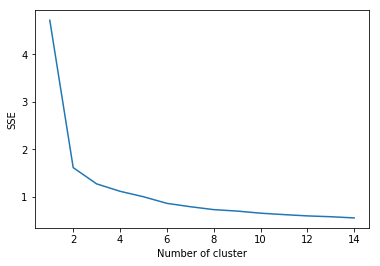

In [99]:
sse = {}
label_track = {}
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(cluster_data_df)
    label_track[k] = kmeans.labels_
    # Inertia: Sum of distances of samples to their closest cluster center
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [101]:
# Let choose total of labels = 6
kclusters = 6
cluster_labels = label_track[kclusters]

# add labels
label_group_df.insert(0, 'Cluster Labels', cluster_labels)

In [102]:
label_group_df.head()

,Cluster Labels,Postcode
0,2,M1B
1,5,M1C
2,5,M1E
3,5,M1G
4,0,M1H


#### Join location data and label data

In [104]:
toronto_neighbor_labeled = toronto_df.merge(label_group_df, how='inner', on=['Postcode'])
toronto_neighbor_labeled.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,2
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,5
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,5
3,M1G,Scarborough,Woburn,43.770992,-79.216917,5
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0


#### Visualize the resulting clusters on map

In [117]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_neighbor_labeled['Latitude'], toronto_neighbor_labeled['Longitude'], toronto_neighbor_labeled['Neighbourhood'], toronto_neighbor_labeled['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters